In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']  # 指定黑体（或其他支持中文的字体）
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [3]:
# 读取图像
img = cv2.imread('car-moire-pattern.tif', cv2.IMREAD_GRAYSCALE)
# 获取图像尺寸
rows, cols = img.shape
print(rows, cols)

246 168


In [4]:
# 应用傅里叶变换
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

(np.float64(-0.5), np.float64(167.5), np.float64(245.5), np.float64(-0.5))

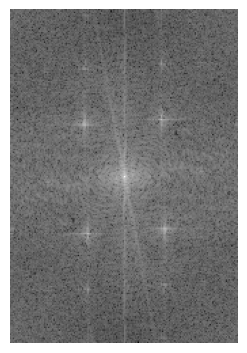

In [5]:
# 计算幅度谱
magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))

# 归一化幅度谱
magnitude_spectrum_normalized = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)

# 转换为8位无符号整型
magnitude_spectrum_8u = cv2.convertScaleAbs(magnitude_spectrum_normalized)


# 使用matplotlib显示幅度谱
plt.figure(figsize=(10, 5))
plt.subplot(132), plt.imshow(magnitude_spectrum_8u, cmap='gray')
plt.axis('off')

In [6]:
# 用于存储点击的点的坐标
noise_centers = []

# 鼠标回调函数，用于记录点击位置
def get_mouse_click(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # 检测到鼠标左键点击
        noise_centers.append((y, x))  # 保存坐标
        print(f"Point {len(noise_centers)}: ({y}, {x})")
        # 在图像上绘制点击的点
        cv2.circle(param, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow('Select Points', param)
        if len(noise_centers) == 8:  # 当点击八个点后，自动退出
            cv2.destroyAllWindows()

In [7]:
# 显示图像，并设置鼠标回调函数
cv2.imshow('Select Points', magnitude_spectrum_8u)
cv2.setMouseCallback('Select Points', get_mouse_click, magnitude_spectrum_8u)

# 等待用户点击八个点
cv2.waitKey(0)

# 输出点击的点坐标
print("Selected Points:", noise_centers)

# 等待并关闭所有窗口
cv2.destroyAllWindows()

Point 1: (44, 55)
Point 2: (40, 112)
Point 3: (81, 111)
Point 4: (86, 55)
Point 5: (166, 56)
Point 6: (162, 113)
Point 7: (207, 57)
Point 8: (204, 114)
Selected Points: [(44, 55), (40, 112), (81, 111), (86, 55), (166, 56), (162, 113), (207, 57), (204, 114)]


In [8]:
# 假设 noise_centers 是一个包含 (x, y) 坐标的列表
for center in noise_centers:
    x, y = center  # 解包元组以获取 x 和 y 坐标
    if 0 <= x < cols and 0 <= y < rows:
        print(f"({x}, {y}) is within the image boundaries.")
    else:
        print(f"({x}, {y}) is out of the image boundaries.")
          
          

(44, 55) is within the image boundaries.
(40, 112) is within the image boundaries.
(81, 111) is within the image boundaries.
(86, 55) is within the image boundaries.
(166, 56) is within the image boundaries.
(162, 113) is within the image boundaries.
(207, 57) is out of the image boundaries.
(204, 114) is out of the image boundaries.


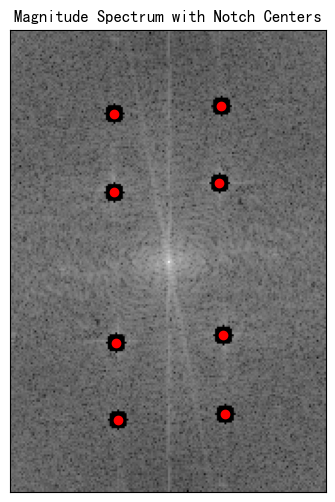

In [9]:
# 在频谱图上标记陷波中心
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum_8u, cmap='gray')
plt.title('Magnitude Spectrum with Notch Centers')

# 绘制红点标记陷波中心
for center in noise_centers:
    plt.scatter(center[1], center[0], color='red')  # 注意：matplotlib的坐标系与OpenCV的坐标系不同

plt.xticks([]), plt.yticks([])
plt.show()

In [10]:
# # 巴特沃斯陷波带阻滤波器函数
# def butterworth_bandstop_filter(shape, center, D0, n):
#     rows, cols = shape
#     mask = np.zeros((rows, cols, 2), np.float32)  # 初始化为全0（黑色）
#     for i in range(rows):
#         for j in range(cols):
#             distance = np.sqrt((i - center[0])**2 + (j - center[1])**2)
#             if distance <= D0:  # 陷波区域
#                 mask[i, j, 0] = 0  # 保持黑色
#                 mask[i, j, 1] = 0
#             else:  # 非陷波区域
#                 mask[i, j, 0] = 1  # 设置为白色
#                 mask[i, j, 1] = 0
#     return mask

In [11]:
# 巴特沃斯陷波带阻滤波器函数
def butterworth_bandstop_filter(shape, center, D0, n):
    rows, cols = shape
    mask = np.ones((rows, cols), np.float32)  # 初始化为全1（白色）
    for i in range(rows):
        for j in range(cols):
            distance = np.sqrt((i - center[0])**2 + (j - center[1])**2)
            # 巴特沃斯滤波器公式
            mask[i, j] = 1 / (1 + (distance / D0)**(2 * n))
    return 1-mask

In [12]:
# # 设定陷波参数
# D0 = 9
# n = 4
# # 创建滤波器掩模
# mask = np.ones((rows, cols, 2), np.float32)
# for center in noise_centers:
#     new_mask = butterworth_bandstop_filter((rows, cols), center, D0, n)
#     # 使用逐元素相乘来组合掩膜
#     mask = np.multiply(mask, new_mask)
# # 应用滤波器
# fshift = dft_shift * mask

In [13]:
# 设定陷波参数
D0 = 9
n = 4
# 创建滤波器掩模
mask = np.ones((rows, cols, 2), np.float32)  # 初始化为全1（白色），形状为 (rows, cols, 2)
for center in noise_centers:
    new_mask = butterworth_bandstop_filter((rows, cols), center, D0, n)
    new_mask = new_mask[..., np.newaxis]  # 将 new_mask 扩展为 (rows, cols, 1)
    
    # 使用逐元素相乘来组合掩膜，扩展后的 new_mask 变为 (rows, cols, 2)
    mask = np.multiply(mask, np.repeat(new_mask, 2, axis=-1))  # 将 new_mask 重复两次，沿第三轴


# 应用滤波器
fshift =dft_shift * mask  # 将掩模应用到频谱上

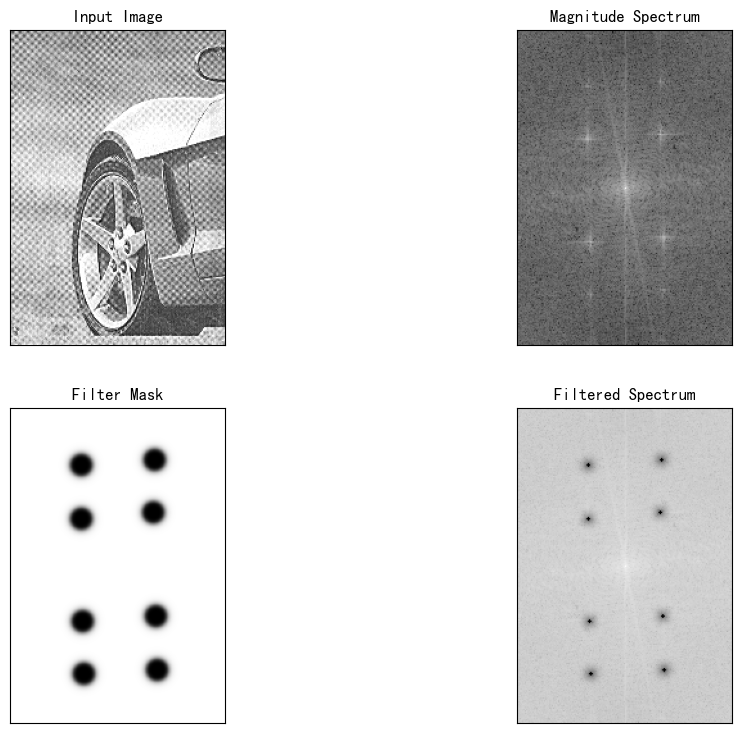

In [14]:
# 显示滤波器掩模与傅里叶变换结果相乘的效果
magnitude_spectrum_filtered = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]) + 1e-10)

plt.figure(figsize=(12, 9))
plt.subplot(221), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(mask[..., 0], cmap='gray')
plt.title('Filter Mask'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_spectrum_filtered, cmap='gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

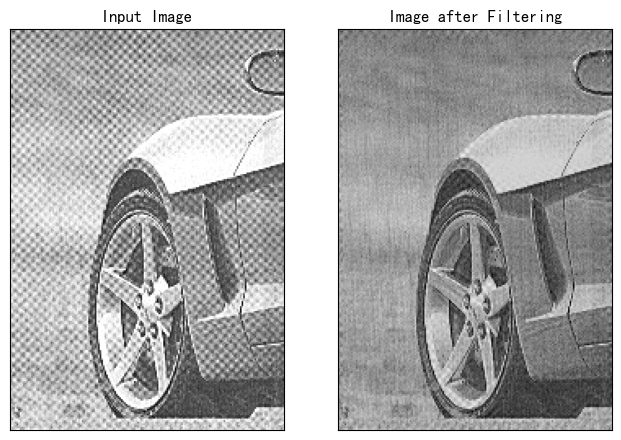

In [15]:
# 逆傅里叶变换
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

# 使用matplotlib显示结果
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(img_back, cmap='gray')
plt.title('Image after Filtering'), plt.xticks([]), plt.yticks([])
plt.show()

频域变换是一种常用于图像处理的技术，通过将图像从空间域（即像素级）转换到频域（即频率级）来进行分析和处理。频域变换主要使用傅里叶变换（Fourier Transform）及其变体，如离散傅里叶变换（DFT）和离散余弦变换（DCT）。频域分析可以帮助我们从不同的角度观察图像特征，许多经典的图像处理算法和应用都依赖于频域变换。

以下是一些经典的图像处理算法和案例，均使用频域变换实现：

### 1. **图像去噪（Noise Reduction）**
频域去噪是最常见的频域应用之一。噪声通常主要集中在高频区域，而图像的细节和边缘信息主要集中在中低频区域。通过过滤高频噪声，可以有效去除图像噪声。

- **低通滤波器（Low-pass Filtering）：** 低通滤波器在频域中允许低频信号通过，同时抑制高频噪声。常见的低通滤波器包括理想低通滤波器、高斯低通滤波器和巴特沃斯低通滤波器。
  
  **应用步骤：**
  1. 将图像转换到频域。
  2. 创建一个低通滤波器，抑制高频部分。
  3. 应用该滤波器，进行频域滤波。
  4. 将结果转换回空间域。

  **案例：** 使用高斯低通滤波器去除图像中的椒盐噪声或高频噪声。

  ```python
  import cv2
  import numpy as np
  import matplotlib.pyplot as plt

  # 读取图像并添加噪声
  img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
  rows, cols = img.shape

  # 添加高斯噪声
  noise = np.random.normal(0, 25, (rows, cols))
  img_noisy = np.uint8(np.clip(img + noise, 0, 255))

  # 应用傅里叶变换
  dft = cv2.dft(np.float32(img_noisy), flags=cv2.DFT_COMPLEX_OUTPUT)
  dft_shift = np.fft.fftshift(dft)

  # 创建高斯低通滤波器
  def gaussian_lowpass_filter(shape, D0):
      rows, cols = shape
      mask = np.zeros((rows, cols), np.float32)
      center = (rows // 2, cols // 2)
      for i in range(rows):
          for j in range(cols):
              D = np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2)
              mask[i, j] = np.exp(-(D ** 2) / (2 * (D0 ** 2)))
      return mask

  D0 = 50  # 截止频率
  mask = gaussian_lowpass_filter(img.shape, D0)
  mask = mask[:, :, np.newaxis]  # 增加一个维度

  # 应用滤波器
  fshift_filtered = dft_shift * mask

  # 逆傅里叶变换
  f_ishift = np.fft.ifftshift(fshift_filtered)
  img_back = cv2.idft(f_ishift)
  img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

  # 显示结果
  plt.figure(figsize=(10, 10))
  plt.subplot(131), plt.imshow(img_noisy, cmap='gray'), plt.title('Noisy Image')
  plt.subplot(132), plt.imshow(np.log(np.abs(dft_shift[:, :, 0]) + 1), cmap='gray'), plt.title('Magnitude Spectrum')
  plt.subplot(133), plt.imshow(img_back, cmap='gray'), plt.title('Filtered Image')
  plt.show()
  ```

### 2. **图像锐化（Sharpening）**
图像锐化可以增强图像中的细节和边缘。频域锐化通常通过应用高通滤波器来增强图像的高频部分。常见的高通滤波器包括理想高通滤波器、高斯高通滤波器和巴特沃斯高通滤波器。

- **高通滤波器（High-pass Filtering）：** 高通滤波器去除低频信息，只保留高频部分，通常用于锐化图像。

  **应用步骤：**
  1. 将图像转换到频域。
  2. 创建一个高通滤波器，抑制低频部分。
  3. 应用该滤波器，进行频域滤波。
  4. 将结果转换回空间域。

  **案例：** 使用高斯高通滤波器锐化图像。

  ```python
  def gaussian_highpass_filter(shape, D0):
      rows, cols = shape
      mask = np.ones((rows, cols), np.float32)
      center = (rows // 2, cols // 2)
      for i in range(rows):
          for j in range(cols):
              D = np.sqrt((i - center[0]) ** 2 + (j - center[1]) ** 2)
              mask[i, j] = 1 - np.exp(-(D ** 2) / (2 * (D0 ** 2)))
      return mask

  D0 = 50  # 截止频率
  mask = gaussian_highpass_filter(img.shape, D0)
  mask = mask[:, :, np.newaxis]  # 增加一个维度

  # 应用高通滤波器
  fshift_filtered = dft_shift * mask

  # 逆傅里叶变换
  f_ishift = np.fft.ifftshift(fshift_filtered)
  img_back = cv2.idft(f_ishift)
  img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

  # 显示结果
  plt.figure(figsize=(10, 10))
  plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original Image')
  plt.subplot(132), plt.imshow(np.log(np.abs(dft_shift[:, :, 0]) + 1), cmap='gray'), plt.title('Magnitude Spectrum')
  plt.subplot(133), plt.imshow(img_back, cmap='gray'), plt.title('Sharpened Image')
  plt.show()
  ```

### 3. **图像压缩（Image Compression）**
离散余弦变换（DCT）常用于图像压缩，例如 JPEG 图像压缩。DCT 可以将图像数据从空间域转换到频域，使得大部分图像能量集中在低频部分，进而可以去除高频信息，达到压缩的效果。

- **DCT压缩：** 使用DCT对图像进行频域变换，然后丢弃低于某个阈值的高频系数，最后进行逆变换。

  **应用步骤：**
  1. 将图像转换到频域（使用 DCT）。
  2. 丢弃低频信息，保留最重要的频域系数。
  3. 使用逆 DCT 重建图像。

  **案例：** 使用 DCT 压缩图像。

  ```python
  def dct_2d(img):
      return cv2.dct(np.float32(img))

  def idct_2d(dct_img):
      return cv2.idct(dct_img)

  img = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)

  # 计算 DCT
  dct_img = dct_2d(img)

  # 保留前 30 个 DCT 系数
  dct_img[30:, :] = 0
  dct_img[:, 30:] = 0

  # 逆 DCT 重建图像
  img_compressed = idct_2d(dct_img)

  plt.figure(figsize=(10, 10))
  plt.subplot(131), plt.imshow(img, cmap='gray'), plt.title('Original Image')
  plt.subplot(132), plt.imshow(np.log(np.abs(dct_img) + 1), cmap='gray'), plt.title('DCT Spectrum')
  plt.subplot(133), plt.imshow(img_compressed, cmap='gray'), plt.title('Compressed Image')
  plt.show()
  ```

### 4. **图像特征提取与匹配**
通过频域变换，图像特征可以通过频率成分进行提取，例如在模式识别、物体检测和图像匹配中，频域可以帮助识别相似的图像特征。

- **频域特征提取：** 使用傅里叶变换提取图像的频域特征，进行模式匹配或对象检测。

### 总结：
频域变换（如傅里叶变换、离散傅里叶变换、离散余弦变换）在图像处理中的应用非常广泛，典型的应用包括图像去噪、锐化、压缩、特征提取等。通过在频

域中操作，我们能够高效地实现一些在空间域中较难处理的任务。